**Required Libraries**

In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

**Load the daily dataset**

In [2]:
daily_data = pd.read_csv('SN_d_tot_V2.0.csv', sep=';', header=None)
daily_data.columns = ['Year', 'Month', 'Day', 'Fractional Year', 'Sunspot Number', 'Std Dev', 'Observations', 'Indicator']
daily_data_cleaned = daily_data[daily_data['Sunspot Number'] != -1]
daily_data_cleaned['Date'] = pd.to_datetime(daily_data_cleaned[['Year', 'Month', 'Day']])
daily_data_prepped = daily_data_cleaned[['Date', 'Sunspot Number']].rename(columns={'Date': 'ds', 'Sunspot Number': 'y'})


<ipython-input-2-5b7c8f5c9027>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_cleaned['Date'] = pd.to_datetime(daily_data_cleaned[['Year', 'Month', 'Day']])


In [4]:
daily_data.head(n=5)

,Year,Month,Day,Fractional Year,Sunspot Number,Std Dev,Observations,Indicator
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


**Define and train the Prophet model**

In [5]:
model = Prophet()
model.fit(daily_data_prepped)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdixv3p3x/k_zbklhg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdixv3p3x/jg8m7lwn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40262', 'data', 'file=/tmp/tmpdixv3p3x/k_zbklhg.json', 'init=/tmp/tmpdixv3p3x/jg8m7lwn.json', 'output', 'file=/tmp/tmpdixv3p3x/prophet_modelomfcbkel/prophet_model-20241128175522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:55:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Define and tune the Prophet model**

In [8]:
model = Prophet(growth='linear', n_changepoints=25, changepoint_prior_scale=0.05)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.fit(daily_data_prepped)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdixv3p3x/ju00xooc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdixv3p3x/0w5jfgon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77399', 'data', 'file=/tmp/tmpdixv3p3x/ju00xooc.json', 'init=/tmp/tmpdixv3p3x/0w5jfgon.json', 'output', 'file=/tmp/tmpdixv3p3x/prophet_modeltook4p7l/prophet_model-20241128181912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Make predictions for 100, 200, and 365 days into the future**

In [9]:
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)

**Filter predictions for specified intervals**

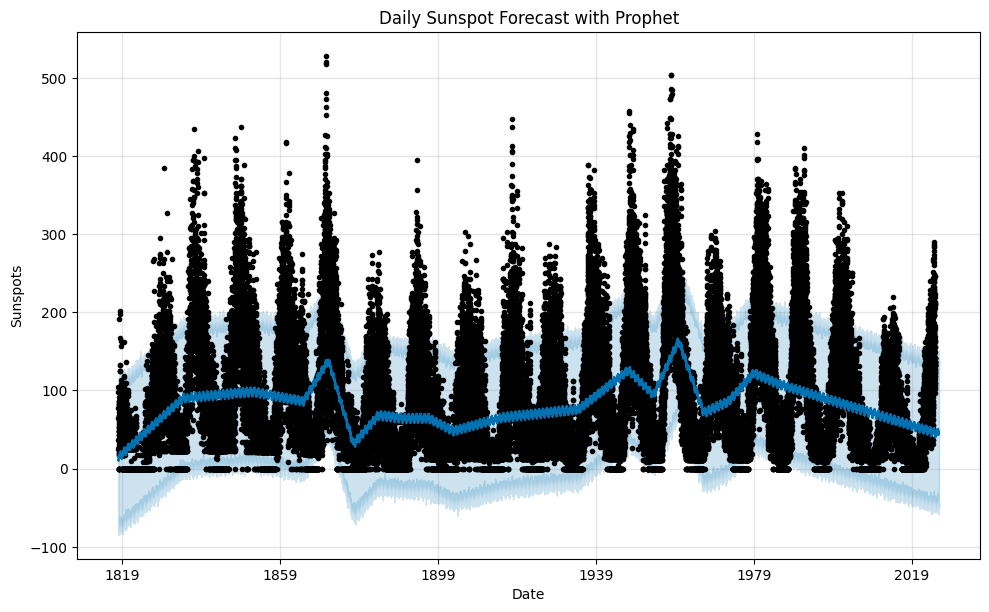

In [12]:
import matplotlib.pyplot as plt
model.plot(forecast)
plt.title("Daily Sunspot Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Sunspots")
plt.savefig("daily_forecast_plot.png")
plt.show()

**Filter predictions for specified intervals**

In [13]:
predicted_intervals = forecast.loc[forecast['ds'].isin(
    [future['ds'].iloc[-100], future['ds'].iloc[-200], future['ds'].iloc[-365]])]

**Evaluate the model**

In [14]:
history = forecast[forecast['ds'] <= daily_data_prepped['ds'].max()]
mae = mean_absolute_error(daily_data_prepped['y'], history['yhat'])
mape = np.mean(np.abs((daily_data_prepped['y'] - history['yhat']) / daily_data_prepped['y'])) * 100
r2 = r2_score(daily_data_prepped['y'], history['yhat'])

**Save the forecast**

In [15]:
forecast.to_csv('daily_forecast.csv', index=False)

**Print metrics and predictions**

In [16]:
print("Daily Forecast Metrics:")
print(f"MAE: {mae}, MAPE: {mape}, R2: {r2}")
print("\nPredicted Sunspots for specified intervals:")
print(predicted_intervals[['ds', 'yhat']])

Daily Forecast Metrics:
MAE: 57.444529105044104, MAPE: inf, R2: 0.14201882735122584

Predicted Sunspots for specified intervals:
              ds       yhat
72298 2024-11-01  45.505704
72463 2025-04-15  45.711926
72563 2025-07-24  44.359216
